[INFO] Input (LLM): outputs/run_001/03_llmcleaned
[INFO] Baseline search order: ['outputs/run_001/02_cleaned', 'outputs/run_001/01_blocks']
[INFO] QA out: outputs/run_001/03a_llmqa
[INFO] Found 8 LLM files
✓ page_001_blocks.domain.llm.json: touched=0/8 avg_edit=1.0000 kept={'orig': 8}
✓ page_002_blocks.domain.llm.json: touched=0/12 avg_edit=1.0000 kept={'orig': 12}
✓ page_003_blocks.domain.llm.json: touched=0/8 avg_edit=1.0000 kept={'orig': 8}
✓ page_004_blocks.domain.llm.json: touched=0/9 avg_edit=1.0000 kept={'orig': 9}
[WARN] Baseline not found for page_1_blocks.domain.llm.json → will assume original text in same file
✓ page_1_blocks.domain.llm.json: touched=0/56 avg_edit=1.0000 kept={'orig': 56}
[WARN] Baseline not found for page_2_blocks.domain.llm.json → will assume original text in same file
✓ page_2_blocks.domain.llm.json: touched=0/74 avg_edit=1.0000 kept={'orig': 74}
[WARN] Baseline not found for page_3_blocks.domain.llm.json → will assume original text in same file
✓ page_3_

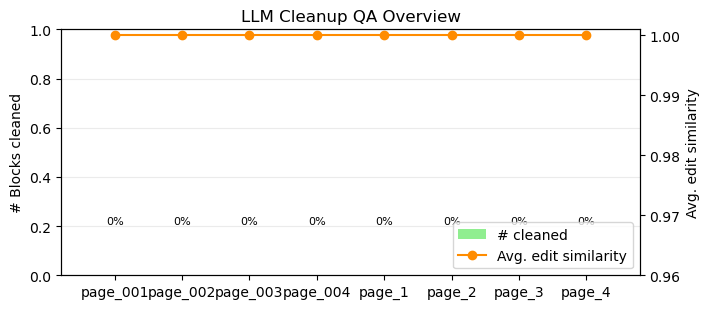

In [2]:
# 03a_llm_cleanup_qa.ipynb  (can also run as a .py script)
# Enhanced QA for LLM cleanup + Visualization

# -----------------------------
# PARAMETERS (papermill-friendly)
# -----------------------------
run_root = "outputs/run_001"           # parent run folder
stage_in = f"{run_root}/03_llmcleaned" # LLM-cleaned blocks
stage_prev_candidates = [              # where the "pre-llm" baseline came from
    f"{run_root}/02_cleaned",
    f"{run_root}/01_blocks",
]
out_dir = f"{run_root}/03a_llmqa"      # where QA CSVs/plots go
min_change_to_count = 0.9995           # similarity >= this -> treated as "no change"
min_len_for_ratio   = 4                # ignore too-short tokens when comparing

# -----------------------------
# Imports
# -----------------------------
import re, json, difflib
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

Path(out_dir).mkdir(parents=True, exist_ok=True)
print(f"[INFO] Input (LLM): {stage_in}")
print(f"[INFO] Baseline search order: {stage_prev_candidates}")
print(f"[INFO] QA out: {out_dir}")

# -----------------------------
# Helpers
# -----------------------------
def read_json(p: Path):
    try:
        return json.loads(p.read_text(encoding="utf-8"))
    except Exception as e:
        print(f"[WARN] Could not read {p}: {e}")
        return []

def seq_sim(a: str, b: str) -> float:
    # Ignore trivial whitespace-only diffs
    A = re.sub(r"\s+", " ", (a or "")).strip()
    B = re.sub(r"\s+", " ", (b or "")).strip()
    if len(A) < min_len_for_ratio and len(B) < min_len_for_ratio:
        return 1.0
    return difflib.SequenceMatcher(None, A, B).ratio()

def should_cleanup(text: str) -> bool:
    if not text or not text.strip():
        return False
    t = text.strip()
    noisy_tokens = ["@@","##","| |","¢","§","�","~~","==","… …","||","— —"]
    if any(tok in t for tok in noisy_tokens):
        return True
    if len(t) < 12 and not t.endswith("."):
        return True
    return False

def find_baseline(stem: str) -> Path | None:
    """
    Given a file stem like 'page_001_blocks.domain.llm', try to find the matching
    pre-LLM file in 02_cleaned or 01_blocks.
    Priority:
      - page_XXX_blocks.domain.json
      - page_XXX_blocks.cleaned.json
      - page_XXX_blocks.json
    """
    base = stem.replace(".llm", "")
    candidates = [
        f"{base}.domain.json",
        f"{base}.cleaned.json",
        f"{base}.json",
    ]
    for folder in stage_prev_candidates:
        root = Path(folder)
        for nm in candidates:
            p = root / nm
            if p.exists():
                return p
    return None

# -----------------------------
# Collect files
# -----------------------------
llm_dir = Path(stage_in)
llm_files = sorted(llm_dir.glob("page_*_blocks*.llm.json"))
if not llm_files:
    # Also allow: page_*_blocks.domain.json already inside llm dir (some runs)
    llm_files = sorted(llm_dir.glob("page_*_blocks*.json"))
    # filter out non-llm if mixed
    llm_files = [p for p in llm_files if p.name.endswith(".llm.json")]

if not llm_files:
    raise FileNotFoundError(f"No LLM-cleaned files in {llm_dir}")

print(f"[INFO] Found {len(llm_files)} LLM files")

# -----------------------------
# Per-file QA
# -----------------------------
page_rows = []
all_block_rows = []

for f in llm_files:
    # Determine page id and a friendly label
    m = re.search(r"(page_\d+)_blocks", f.name)
    page_id = m.group(1) if m else f.stem
    stem_no_ext = f.name[:-5]  # drop '.json'
    stem_llm = stem_no_ext     # includes ".llm" in the stem

    # Load LLM-cleaned blocks
    llm_blocks = read_json(f)

    # Find baseline
    baseline_path = find_baseline(stem_llm)
    if not baseline_path:
        print(f"[WARN] Baseline not found for {f.name} → will assume original text in same file")
        baseline_blocks = llm_blocks
    else:
        baseline_blocks = read_json(baseline_path)

    # Build index: we compare by position (i) not by bbox (simple, robust enough here)
    total = min(len(llm_blocks), len(baseline_blocks))
    touched = 0
    eligible = 0
    sim_sum = 0.0

    for i in range(total):
        b_llm = llm_blocks[i]
        b_pre = baseline_blocks[i]

        t0 = (b_pre.get("text_llm") or b_pre.get("text_cleaned") or b_pre.get("text") or "").strip()
        t1 = (b_llm.get("text_llm") or b_llm.get("text_cleaned") or b_llm.get("text") or "").strip()

        # "eligible" approximates blocks LLM *should* consider
        if should_cleanup(t0):
            eligible += 1

        s = seq_sim(t0, t1)
        sim_sum += s
        changed = s < min_change_to_count

        if changed and ("text_llm" in b_llm):
            touched += 1

        all_block_rows.append({
            "page": page_id,
            "index": i,
            "orig_len": len(t0),
            "final_len": len(t1),
            "similarity": round(s, 4),
            "changed": bool(changed),
            "eligible": bool(should_cleanup(t0)),
            "source_file": f.name,
        })

    avg_edit = (sim_sum / total) if total else 1.0
    page_rows.append({
        "page": page_id,
        "file": f.name,
        "total": total,
        "eligible": eligible,
        "touched": touched,
        "avg_edit": round(avg_edit, 4),
    })
    print(f"✓ {f.name}: touched={touched}/{total} avg_edit={avg_edit:.4f} kept={{'orig': {total - touched}}}")

# -----------------------------
# Save per-block & per-page CSVs
# -----------------------------
df_blocks = pd.DataFrame(all_block_rows)
df_pages  = pd.DataFrame(page_rows).sort_values("page")

df_blocks_path = Path(out_dir) / "llm_cleanup_blocks.csv"
df_pages_path  = Path(out_dir) / "llm_cleanup_pages.csv"
df_blocks.to_csv(df_blocks_path, index=False)
df_pages.to_csv(df_pages_path, index=False)

print("\n=== Run Summary ===")
for _, r in df_pages.iterrows():
    print(f"{r['file']}: touched={int(r['touched'])}/{int(r['total'])} avg_edit={r['avg_edit']:.4f}")

print(f"\nSaved per-block → {df_blocks_path}")
print(f"Saved per-page  → {df_pages_path}")

# -----------------------------
# Visualization: bar (touched) + line (avg_edit)
# -----------------------------
plt.figure(figsize=(7.2, 3.2))
ax = plt.gca()

# X labels – compact page ids
x = df_pages["page"]
ax.bar(x, df_pages["touched"], color="#90EE90", label="# cleaned")

ax2 = ax.twinx()
ax2.plot(x, df_pages["avg_edit"], marker="o", color="#ff8c00", label="Avg. edit similarity")

ax.set_ylabel("# Blocks cleaned")
ax2.set_ylabel("Avg. edit similarity")
ax.set_title("LLM Cleanup QA Overview")

# Annotate % cleaned (touched/total) above bars
for xi, t, tot in zip(x, df_pages["touched"], df_pages["total"]):
    pct = (t / tot * 100) if tot else 0
    ax.text(xi, t + 0.2, f"{pct:.0f}%", ha="center", va="bottom", fontsize=8)

# Legends & layout
ax.set_ylim(0, max(1, df_pages["touched"].max() * 1.25))
ax2.set_ylim(0.96, 1.001)
plt.xticks(rotation=15, ha='right')
ax.grid(axis="y", alpha=0.25)

# Merge legends
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="lower right")

plt.tight_layout()
plot_path = Path(out_dir) / "_qa_llmcleanup_summary.png"
plt.savefig(plot_path, dpi=150)
print(f"Saved QA plot → {plot_path}")

# -----------------------------
# Optional: Top-N most changed blocks (for spot-check)
# -----------------------------
TOP_N = 12
if not df_blocks.empty:
    worst = df_blocks.sort_values("similarity").head(TOP_N)
    worst_path = Path(out_dir) / "top_changed_blocks.csv"
    worst.to_csv(worst_path, index=False)
    print(f"Saved Top-{TOP_N} changed blocks → {worst_path}")
